0it [00:00, ?it/s]                


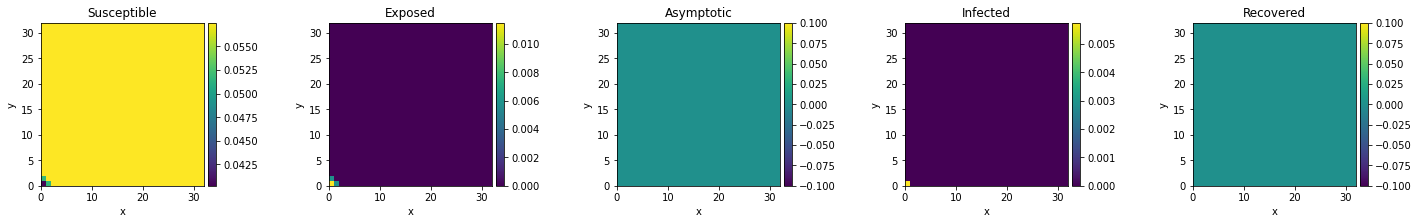

100%|██████████| 0.1/0.1 [00:03<00:00, 38.18s/it]    
100%|██████████| 0.2/0.2 [00:00<00:00,  2.25it/s]    
100%|██████████| 0.30000000000000004/0.30000000000000004 [00:00<00:00,  2.88it/s]
100%|██████████| 0.4/0.4 [00:00<00:00,  3.60it/s]    
100%|██████████| 0.5/0.5 [00:00<00:00,  4.59it/s]    
100%|██████████| 0.6000000000000001/0.6000000000000001 [00:00<00:00,  5.94it/s]
100%|██████████| 0.7000000000000001/0.7000000000000001 [00:00<00:00,  6.14it/s]
100%|██████████| 0.8/0.8 [00:00<00:00,  6.96it/s]    
100%|██████████| 0.9/0.9 [00:00<00:00,  8.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.17it/s]    
100%|██████████| 1.1/1.1 [00:00<00:00,  9.91it/s]    
100%|██████████| 1.2000000000000002/1.2000000000000002 [00:00<00:00,  8.82it/s]
100%|██████████| 1.3/1.3 [00:00<00:00, 10.00it/s]    
100%|██████████| 1.4000000000000001/1.4000000000000001 [00:00<00:00, 12.84it/s]
100%|██████████| 1.5/1.5 [00:00<00:00, 11.45it/s]    
100%|██████████| 1.6/1.6 [00:00<00:00, 12.31it/s]    
100%

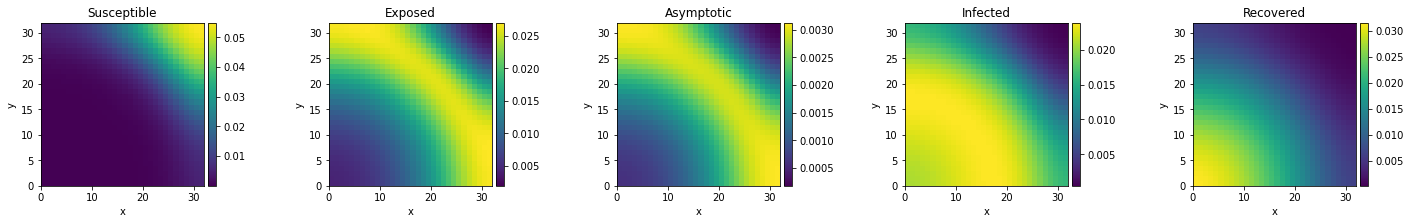

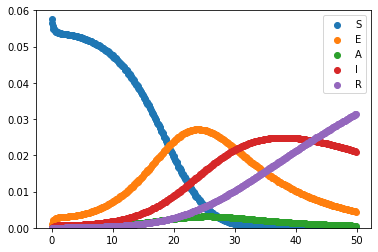

In [24]:
from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid
import numpy as np
import matplotlib.pyplot as plt

class SIRPDE(PDEBase):
    """SIR-model with diffusive mobility"""

    def __init__(
        self, alpha = 20, beta = 20, gamma = 0.1, sigma = 0.8, mu = 0.05, d_1 = 0.9, d_2 = 0.9, d_3 = 0.9, d_4 = 0.9, d_5 = 0.9, bc = "auto_periodic_neumann"
    ):
        self.alpha = alpha
        self.beta = beta  # transmission rate
        self.gamma = gamma  # recovery rate
        self.sigma = sigma
        self.mu = mu
        self.d_1 = d_1  # spatial mobility
        self.d_2 = d_2
        self.d_3 = d_3
        self.d_4 = d_4
        self.d_5 = d_5
        self.bc = bc  # boundary condition

    def get_state(self, s, e, a, i):
        """generate a suitable initial state"""
        # norm = (s + e + a + i).data.max()  # maximal density
        # if norm > 1:
        #     s /= norm
        #     e /= norm
        #     a /= norm
        #     i /= norm
        s.label = "Susceptible"
        e.label ="Exposed"
        a.label = "Asymptotic"
        i.label = "Infected"

        # # create recovered field
        # r = ScalarField(s.grid, data = 1 - s - e - a - i, label="Recovered")
        r = ScalarField.from_expression(s.grid, '0')
        r.label = "Recovered"
        return FieldCollection([s, e, a, i, r])

    def evolution_rate(self, state, t=0):
        s, e, a, i, r = state
        d_1 = self.d_1
        d_2 = self.d_2
        d_3 = self.d_3
        d_4 = self.d_4
        d_5 = self.d_5
        ds_dt = d_1 * s.laplace(self.bc) - self.alpha * a * s - self.beta * i * s
        de_dt = d_2 * e.laplace(self.bc) + self.alpha * a * s + self.beta * i * s - self.gamma * e
        da_dt = d_3 * a.laplace(self.bc) + self.gamma * e - self.sigma * a - self.mu * a        
        di_dt = d_4 * i.laplace(self.bc) + self.sigma * a - self.mu * i
        dr_dt = d_5 * r.laplace(self.bc) + self.mu * a + self.mu * i
        return FieldCollection([ds_dt, de_dt, da_dt, di_dt, dr_dt])


eq = SIRPDE(beta=20, gamma=0.1)

# initialize state


grid = UnitGrid([32, 32])
s = ScalarField.from_expression(grid, '0.05749')
e = ScalarField.from_expression(grid, '0')
a = ScalarField.from_expression(grid, '0')
i = ScalarField.from_expression(grid, '0')
i.data[0, 0] = 0.1*0.05749
e.data[0, 0] = 0.2*0.05749
e.data[0, 1] = 0.1*0.05749
e.data[1, 0] = 0.1*0.05749
s.data[0, 0] = 0.7*0.05749
s.data[0, 1] = 0.9*0.05749
s.data[1, 0] = 0.9*0.05749
# i.data[31, 31] = 1
state = eq.get_state(s, e, a, i)

# simulate the pde
k = 500
solution = np.zeros((k,6))
m = 1
solution[0,0] = 0
solution[0,1] = s.data[m, m]
solution[0,2] = e.data[m, m]
solution[0,3] = a.data[m, m]
solution[0,4] = i.data[m, m]
solution[0,5] = 0
sol = eq.solve(state, t_range = 0 , dt = 0.1)
sol.plot()
 

for i in range(k - 1):
    solution[i + 1,0] = 0.1*(i + 1)
# tracker = PlotTracker(interval=10, plot_args={"vmin": 0, "vmax": 1})
# sol = eq.solve(state, t_range=50, dt=1e-2, tracker=["progress", tracker])
    sol = eq.solve(state, t_range = (i + 1)*0.1 , dt = 0.1 )
    
    solution[i+1,1] = sol['Susceptible'].data[m,m]
    solution[i+1,2] = sol['Exposed'].data[m,m]
    solution[i+1,3] = sol['Asymptotic'].data[m,m]
    solution[i+1,4] = sol['Infected'].data[m,m]
    solution[i+1,5] = sol['Recovered'].data[m,m]

sol.plot()
plt.scatter(solution[:,0],solution[:,1],label = 'S')
plt.scatter(solution[:,0],solution[:,2],label = 'E')
plt.scatter(solution[:,0],solution[:,3],label = 'A')
plt.scatter(solution[:,0],solution[:,4],label = 'I')
plt.scatter(solution[:,0],solution[:,5],label = 'R')

plt.ylim(0.00, 0.06)
plt.legend()
plt.show()


Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

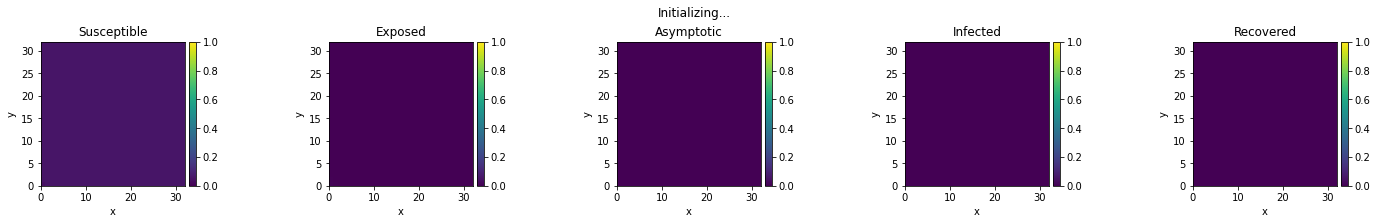

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

  6%|▌         | 2.9/50.0 [00:05<01:33,  1.98s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 12.7/50.0 [00:06<00:18,  2.06it/s]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 28.0/50.0 [00:06<00:05,  4.20it/s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 49.4/50.0 [00:07<00:00,  6.61it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:07<00:00,  6.43it/s]
Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

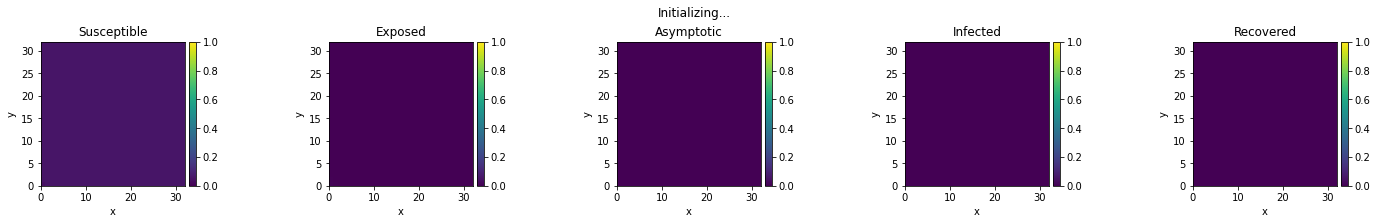

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

  8%|▊         | 4.1/50.0 [00:01<00:16,  2.74it/s] 

<Figure size 432x288 with 0 Axes>

 30%|███       | 15.25/50.0 [00:02<00:04,  7.51it/s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 61%|██████    | 30.35/50.0 [00:02<00:01, 10.18it/s]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 45.95/50.0 [00:03<00:00, 12.65it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:04<00:00, 12.46it/s] 
Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

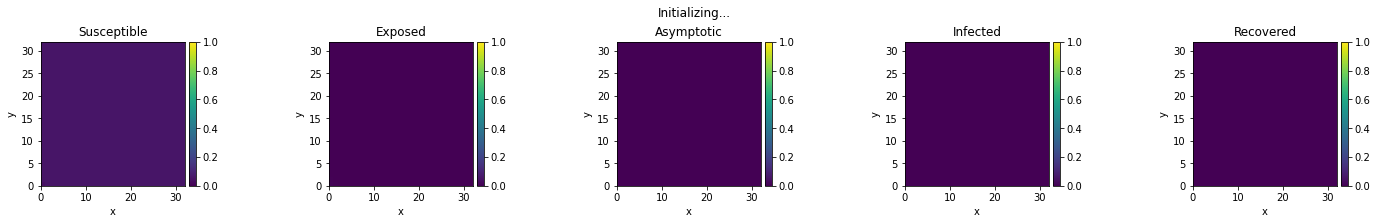

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 7.675/50.0 [00:01<00:09,  4.37it/s]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 17.775/50.0 [00:02<00:04,  6.94it/s]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 29.0/50.0 [00:03<00:02,  8.40it/s]  

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 40.875/50.0 [00:04<00:01,  8.82it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:05<00:00,  9.29it/s]  
Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

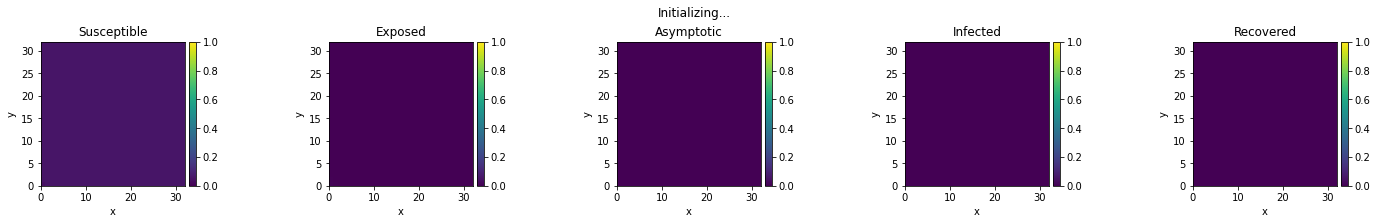

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 11%|█         | 5.4/50.0 [00:02<00:18,  2.42it/s]      

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 17.225/50.0 [00:03<00:07,  4.65it/s]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 24.9/50.0 [00:04<00:04,  5.24it/s]  

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 39.6875/50.0 [00:06<00:01,  5.97it/s]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 47.6875/50.0 [00:07<00:00,  6.12it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:08<00:00,  6.02it/s]   
Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

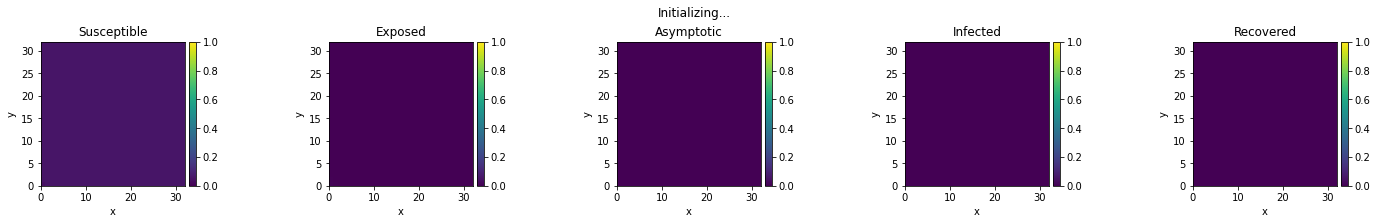

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 6.59375/50.0 [00:02<00:18,  2.31it/s]  

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 18.03125/50.0 [00:05<00:09,  3.27it/s]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 26.43125/50.0 [00:07<00:07,  3.36it/s]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 36.9375/50.0 [00:11<00:03,  3.31it/s] 

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 48.85625/50.0 [00:15<00:00,  3.13it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:16<00:00,  3.07it/s]    
Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

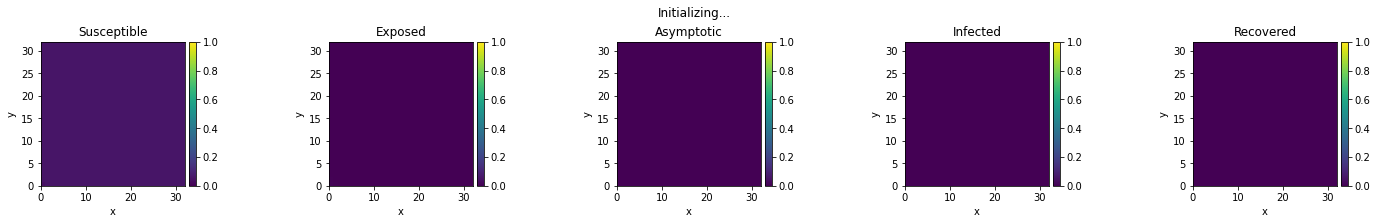

  0%|          | 0/50.0 [00:00<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 9.644/50.0 [00:15<01:03,  1.58s/it]   

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 19.593/50.0 [00:30<00:46,  1.54s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 29.588/50.0 [00:44<00:30,  1.49s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 39.478/50.0 [00:58<00:15,  1.48s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 49.518/50.0 [01:12<00:00,  1.46s/it]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [01:13<00:00,  1.46s/it]  

[[7.76361056e-07 4.43486866e-03 5.91193074e-04 2.09753072e-02
  3.14878547e-02]
 [7.87589184e-07 4.41922661e-03 5.89106116e-04 2.09298079e-02
  3.15510718e-02]
 [7.99362470e-07 4.42064927e-03 5.89294020e-04 2.09195835e-02
  3.15596739e-02]
 [7.99469844e-07 4.41210697e-03 5.88155211e-04 2.09018450e-02
  3.15870933e-02]
 [7.99539079e-07 4.40784032e-03 5.87586402e-04 2.08929693e-02
  3.16008044e-02]
 [7.99370109e-07 4.40388975e-03 5.87059767e-04 2.08850059e-02
  3.16132452e-02]]


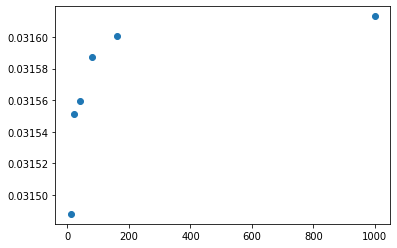

In [5]:
from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid
import numpy as np
import matplotlib.pyplot as plt

class SIRPDE(PDEBase):
    """SIR-model with diffusive mobility"""

    def __init__(
        self, alpha = 20, beta = 20, gamma = 0.1, sigma = 0.8, mu = 0.05, d_1 = 0.9, d_2 = 0.9, d_3 = 0.9, d_4 = 0.9, d_5 = 0.9, bc = "auto_periodic_neumann"
    ):
        self.alpha = alpha
        self.beta = beta  # transmission rate
        self.gamma = gamma  # recovery rate
        self.sigma = sigma
        self.mu = mu
        self.d_1 = d_1  # spatial mobility
        self.d_2 = d_2
        self.d_3 = d_3
        self.d_4 = d_4
        self.d_5 = d_5
        self.bc = bc  # boundary condition

    def get_state(self, s, e, a, i):
        """generate a suitable initial state"""
        # norm = (s + e + a + i).data.max()  # maximal density
        # if norm > 1:
        #     s /= norm
        #     e /= norm
        #     a /= norm
        #     i /= norm
        s.label = "Susceptible"
        e.label ="Exposed"
        a.label = "Asymptotic"
        i.label = "Infected"

        # # create recovered field
        # r = ScalarField(s.grid, data = 1 - s - e - a - i, label="Recovered")
        r = ScalarField.from_expression(s.grid, '0')
        r.label = "Recovered"
        return FieldCollection([s, e, a, i, r])

    def evolution_rate(self, state, t=0):
        s, e, a, i, r = state
        d_1 = self.d_1
        d_2 = self.d_2
        d_3 = self.d_3
        d_4 = self.d_4
        d_5 = self.d_5
        ds_dt = d_1 * s.laplace(self.bc) - self.alpha * a * s - self.beta * i * s
        de_dt = d_2 * e.laplace(self.bc) + self.alpha * a * s + self.beta * i * s - self.gamma * e
        da_dt = d_3 * a.laplace(self.bc) + self.gamma * e - self.sigma * a - self.mu * a        
        di_dt = d_4 * i.laplace(self.bc) + self.sigma * a - self.mu * i
        dr_dt = d_5 * r.laplace(self.bc) + self.mu * a + self.mu * i
        return FieldCollection([ds_dt, de_dt, da_dt, di_dt, dr_dt])


eq = SIRPDE(beta=20, gamma=0.1)

# initialize state


grid = UnitGrid([32, 32])
s = ScalarField.from_expression(grid, '0.05749')
e = ScalarField.from_expression(grid, '0')
a = ScalarField.from_expression(grid, '0')
i = ScalarField.from_expression(grid, '0')
i.data[0, 0] = 0.1*0.05749
e.data[0, 0] = 0.2*0.05749
e.data[0, 1] = 0.1*0.05749
e.data[1, 0] = 0.1*0.05749
s.data[0, 0] = 0.7*0.05749
s.data[0, 1] = 0.9*0.05749
s.data[1, 0] = 0.9*0.05749
# i.data[31, 31] = 1
state = eq.get_state(s, e, a, i)

# simulate the pde

m = 1
solution = np.zeros((6,5)) 
i = 0
for j in [10, 20, 40, 80, 160, 1000]:
    
    tracker = PlotTracker(interval=10, plot_args={"vmin": 0, "vmax": 1})
    sol = eq.solve(state, t_range=50, dt=1.0/j, tracker=["progress", tracker])
    
    
    solution[i,0] = sol['Susceptible'].data[m,m]
    solution[i,1] = sol['Exposed'].data[m,m]
    solution[i,2] = sol['Asymptotic'].data[m,m]
    solution[i,3] = sol['Infected'].data[m,m]
    solution[i,4] = sol['Recovered'].data[m,m]
    i += 1
print(solution)
plt.scatter(np.array([1.0/10, 1.0/20, 1.0/40, 1.0/80, 1.0/160, 1.0/1000]).T,solution[:,4])
plt.show()


ValueError: x and y must be the same size

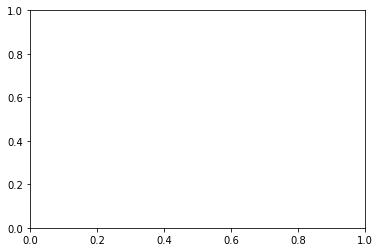

In [4]:

plt.scatter(np.array([1.0/10, 1.0/20, 1.0/40, 1.0/80, 1.0/160, 1.0/1000]).T, solution[:,3])
plt.show()
print(solution[:,3])


Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

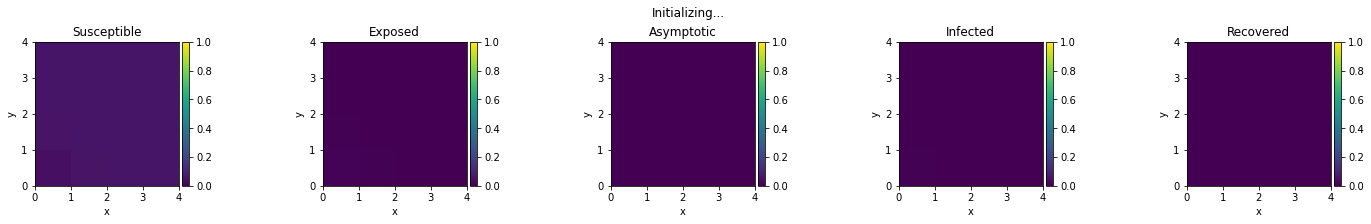

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 8.75/50.0 [00:06<00:28,  1.45it/s]   

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 14.62/50.0 [00:06<00:16,  2.09it/s]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 26.74/50.0 [00:08<00:07,  3.06it/s]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 33.65/50.0 [00:09<00:04,  3.42it/s]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 46.62/50.0 [00:11<00:00,  4.00it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:12<00:00,  4.05it/s] 


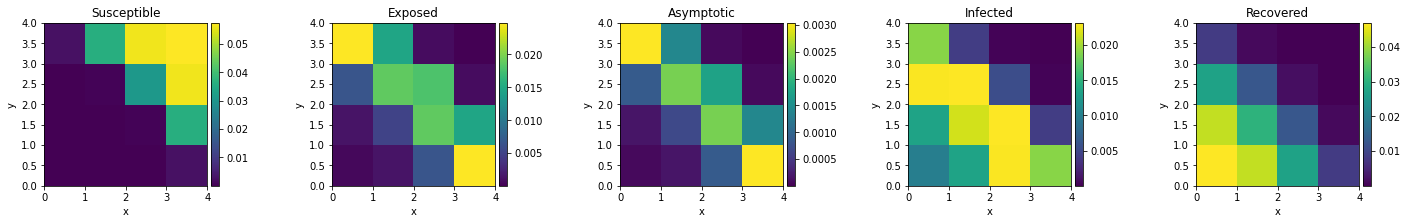

Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

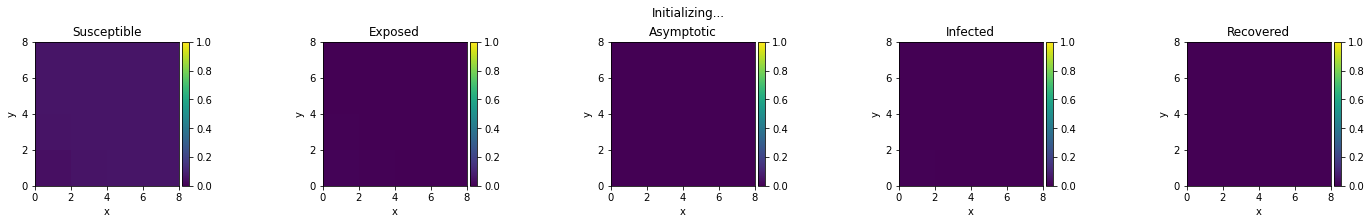

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 11%|█         | 5.62/50.0 [00:05<00:44,  1.01it/s]   

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 15.96/50.0 [00:07<00:15,  2.24it/s]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 28.91/50.0 [00:09<00:06,  3.21it/s]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 35.98/50.0 [00:10<00:03,  3.56it/s]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 49.11/50.0 [00:12<00:00,  4.09it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:12<00:00,  4.04it/s] 


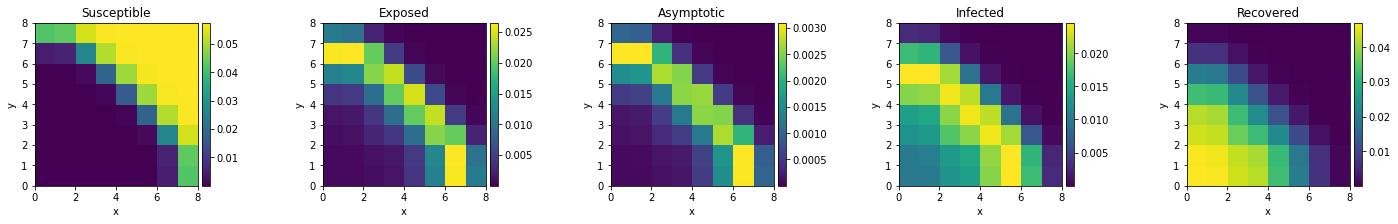

Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

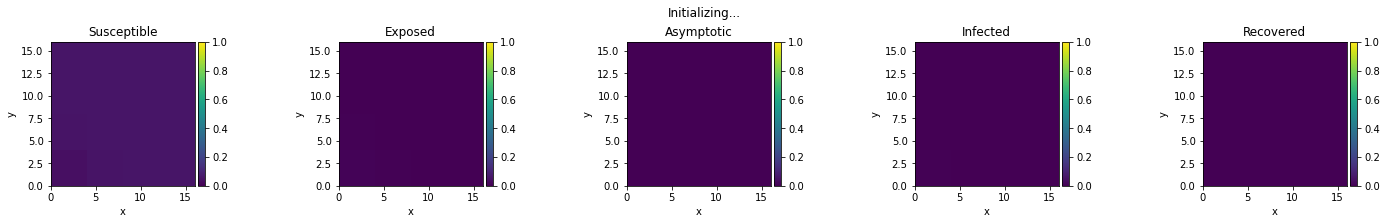

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 7.44/50.0 [00:06<00:34,  1.23it/s]   

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 18.98/50.0 [00:07<00:12,  2.44it/s]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 25.76/50.0 [00:08<00:08,  2.90it/s]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 38.09/50.0 [00:10<00:03,  3.50it/s]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 44.69/50.0 [00:11<00:01,  3.73it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:12<00:00,  3.87it/s] 


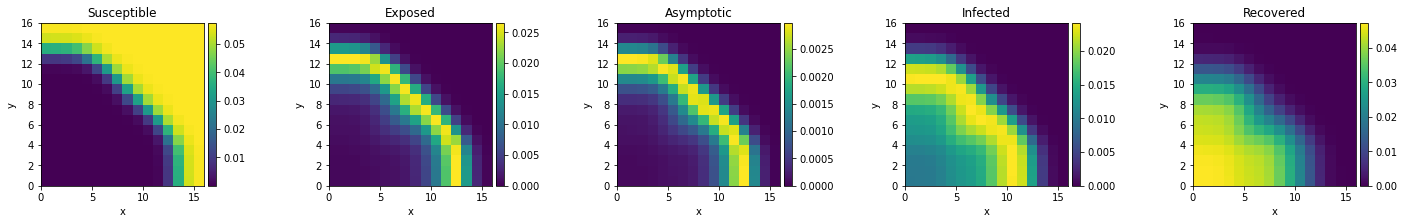

Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

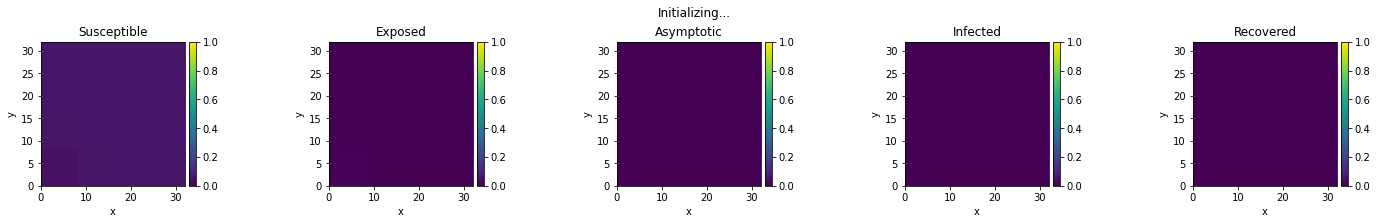

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 14%|█▎        | 6.84/50.0 [00:06<00:40,  1.06it/s]   

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 16.68/50.0 [00:08<00:16,  2.02it/s]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 27.66/50.0 [00:10<00:08,  2.73it/s]

<Figure size 432x288 with 0 Axes>

 79%|███████▊  | 39.3/50.0 [00:12<00:03,  3.24it/s] 

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 45.45/50.0 [00:13<00:01,  3.41it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:14<00:00,  3.51it/s] 


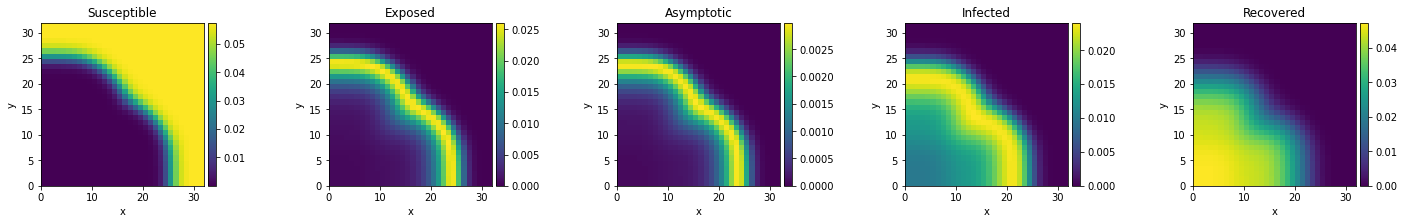

Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

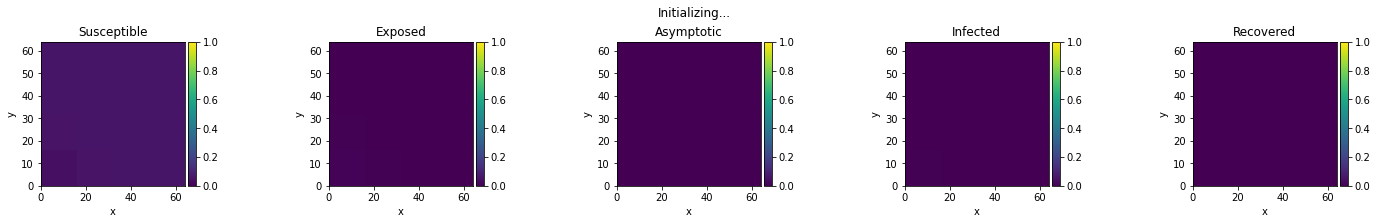

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 7.85/50.0 [00:06<00:37,  1.12it/s]   

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 15.87/50.0 [00:08<00:19,  1.78it/s]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 28.48/50.0 [00:11<00:08,  2.41it/s]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 37.32/50.0 [00:13<00:04,  2.69it/s]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 45.98/50.0 [00:15<00:01,  2.89it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:16<00:00,  2.95it/s] 


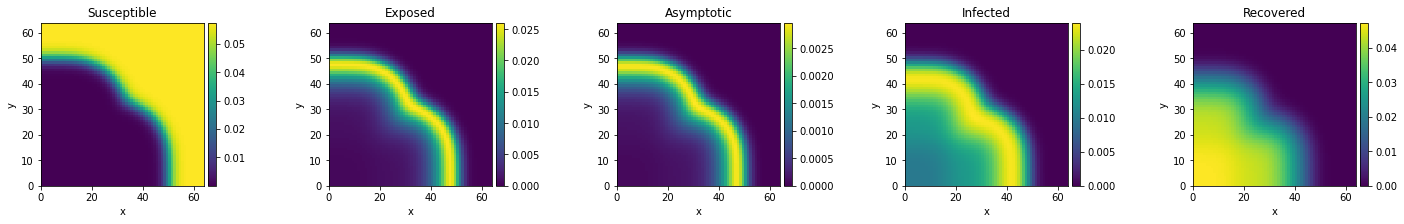

Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

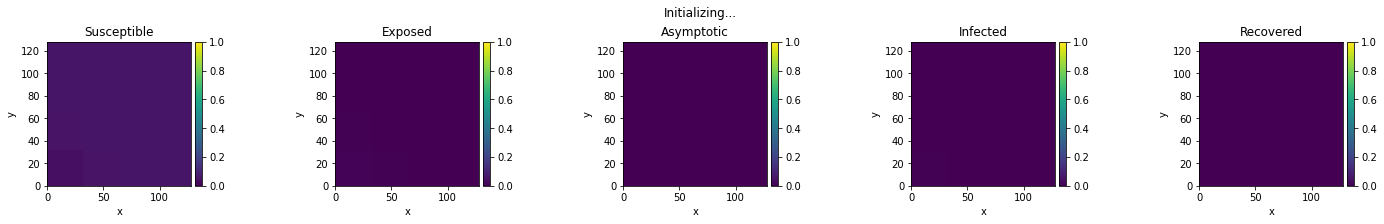

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 7.77/50.0 [00:08<00:44,  1.06s/it]   

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 19.7/50.0 [00:13<00:20,  1.49it/s] 

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 29.23/50.0 [00:17<00:12,  1.69it/s]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 38.82/50.0 [00:21<00:06,  1.82it/s]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 48.65/50.0 [00:25<00:00,  1.93it/s]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [00:26<00:00,  1.92it/s] 


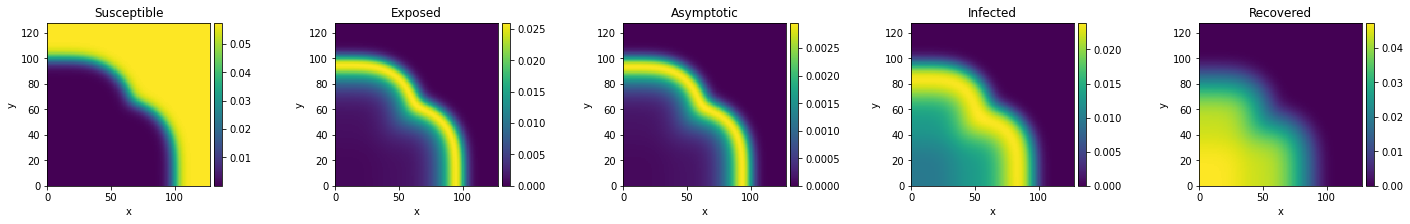

Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

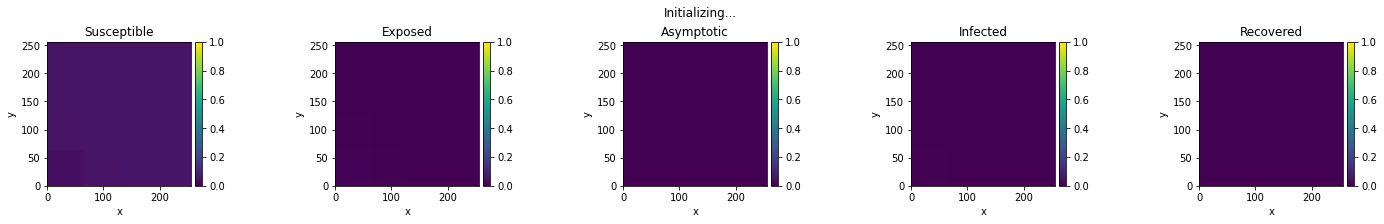

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 9.77/50.0 [00:33<02:16,  3.39s/it]   

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 19.94/50.0 [01:02<01:33,  3.12s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 29.77/50.0 [01:31<01:02,  3.08s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 39.8/50.0 [02:00<00:30,  3.03s/it] 

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 49.75/50.0 [02:28<00:00,  2.98s/it]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [02:29<00:00,  2.99s/it] 


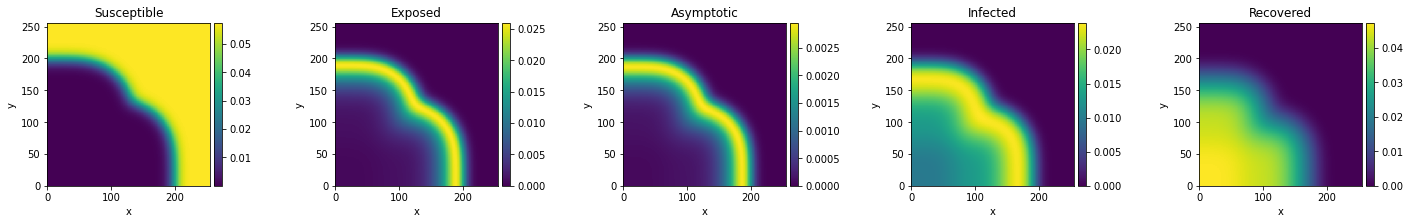

Initializing:   0%|          | 0/50.0 [00:00<?, ?it/s]

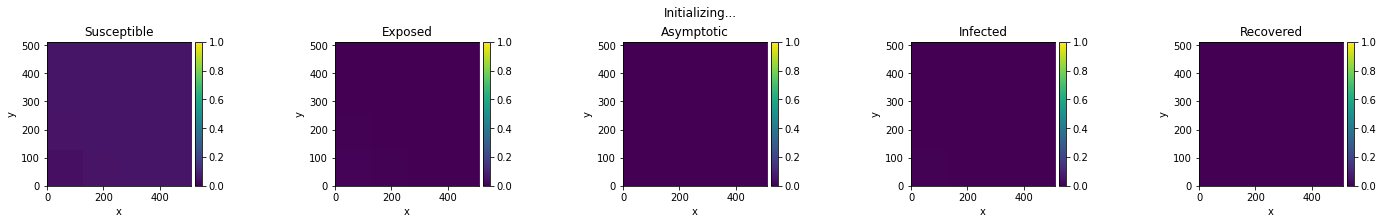

  0%|          | 0/50.0 [00:01<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 9.98/50.0 [02:30<10:04, 15.10s/it]   

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 19.98/50.0 [04:56<07:25, 14.83s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 29.97/50.0 [07:22<04:55, 14.75s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 39.95/50.0 [09:45<02:27, 14.66s/it]

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [12:11<00:00, 14.63s/it] 

<Figure size 432x288 with 0 Axes>

100%|██████████| 50.0/50.0 [12:11<00:00, 14.63s/it]


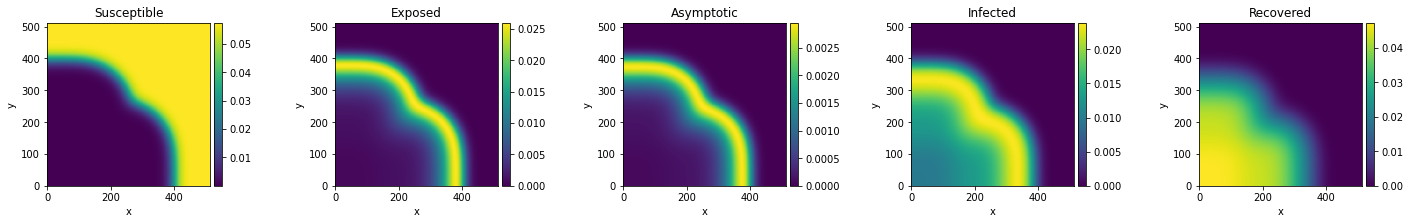

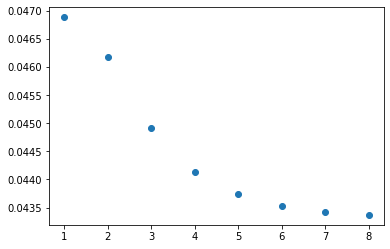

In [2]:
from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid
import numpy as np
import matplotlib.pyplot as plt

class SIRPDE(PDEBase):
    """SIR-model with diffusive mobility"""

    def __init__(
        self, alpha = 20, beta = 20, gamma = 0.1, sigma = 0.8, mu = 0.05, d_1 = 0.9, d_2 = 0.9, d_3 = 0.9, d_4 = 0.9, d_5 = 0.9, bc = "auto_periodic_neumann"
    ):
        self.alpha = alpha
        self.beta = beta  # transmission rate
        self.gamma = gamma  # recovery rate
        self.sigma = sigma
        self.mu = mu
        self.d_1 = d_1  # spatial mobility
        self.d_2 = d_2
        self.d_3 = d_3
        self.d_4 = d_4
        self.d_5 = d_5
        self.bc = bc  # boundary condition

    def get_state(self, s, e, a, i):
        """generate a suitable initial state"""
        # norm = (s + e + a + i).data.max()  # maximal density
        # if norm > 1:
        #     s /= norm
        #     e /= norm
        #     a /= norm
        #     i /= norm
        s.label = "Susceptible"
        e.label ="Exposed"
        a.label = "Asymptotic"
        i.label = "Infected"

        # # create recovered field
        # r = ScalarField(s.grid, data = 1 - s - e - a - i, label="Recovered")
        r = ScalarField.from_expression(s.grid, '0')
        r.label = "Recovered"
        return FieldCollection([s, e, a, i, r])

    def evolution_rate(self, state, t=0):
        s, e, a, i, r = state
        d_1 = self.d_1
        d_2 = self.d_2
        d_3 = self.d_3
        d_4 = self.d_4
        d_5 = self.d_5
        ds_dt = d_1 * s.laplace(self.bc) - self.alpha * a * s - self.beta * i * s
        de_dt = d_2 * e.laplace(self.bc) + self.alpha * a * s + self.beta * i * s - self.gamma * e
        da_dt = d_3 * a.laplace(self.bc) + self.gamma * e - self.sigma * a - self.mu * a        
        di_dt = d_4 * i.laplace(self.bc) + self.sigma * a - self.mu * i
        dr_dt = d_5 * r.laplace(self.bc) + self.mu * a + self.mu * i
        return FieldCollection([ds_dt, de_dt, da_dt, di_dt, dr_dt])



solution = np.zeros((8,6)) 
# initialize state
index = 0
for F in [1,2,4,8,16,32,64,128]:
    L = F/32
    eq = SIRPDE(alpha = 20, beta = 20, gamma = 0.1, sigma = 0.8, mu = 0.05, d_1 = (L**2)*0.9, d_2 = (L**2)*0.9, d_3 = (L**2)*0.9, d_4 = (L**2)*0.9, d_5 = (L**2)*0.9)    
    grid = UnitGrid([4*F, 4*F])
    s = ScalarField.from_expression(grid, '0.05749')
    e = ScalarField.from_expression(grid, '0')
    a = ScalarField.from_expression(grid, '0')
    i = ScalarField.from_expression(grid, '0')
    
    for m in range(F):
        for n in range(F):
            i.data[m, n] = 0.1*0.05749
            e.data[m, n] = 0.2*0.05749
            e.data[m, F + n] = 0.1*0.05749
            e.data[F + m, n] = 0.1*0.05749
            s.data[m, n] = 0.7*0.05749
            s.data[m, F + n] = 0.9*0.05749
            s.data[F + m, n] = 0.9*0.05749
    # i.data[31, 31] = 1
    state = eq.get_state(s, e, a, i)

    # simulate the pde
        
    tracker = PlotTracker(interval=10, plot_args={"vmin": 0, "vmax": 1})
    sol = eq.solve(state, t_range=50, dt=0.01, tracker=["progress", tracker])
    sol.plot()
    
    solution[index, 0] = sol['Susceptible'].data[F-1,F-1]
    solution[index, 1] = sol['Exposed'].data[F-1,F-1]
    solution[index, 2] = sol['Asymptotic'].data[F-1,F-1]
    solution[index, 3] = sol['Infected'].data[F-1,F-1]
    solution[index, 4] = sol['Recovered'].data[F-1,F-1]
    solution[index, 5] = index + 1
    index += 1
plt.scatter(solution[:,5],solution[:,4])
plt.show()

[[1.14552838e-08 5.82426877e-04 7.76563652e-05 9.94629286e-03
  4.68836124e-02 1.00000000e+00]
 [5.69308921e-09 6.85241548e-04 9.13652517e-05 1.05448351e-02
  4.61685524e-02 2.00000000e+00]
 [6.30312411e-09 8.72964488e-04 1.16394902e-04 1.15933889e-02
  4.49072454e-02 3.00000000e+00]
 [8.18169187e-09 9.96779479e-04 1.32903419e-04 1.22316136e-02
  4.41286953e-02 4.00000000e+00]
 [1.01903410e-08 1.06342360e-03 1.41789151e-04 1.25393677e-02
  4.37454093e-02 5.00000000e+00]
 [1.16211179e-08 1.10114754e-03 1.46818901e-04 1.27052718e-02
  4.35367501e-02 6.00000000e+00]
 [1.25022941e-08 1.12247003e-03 1.49661831e-04 1.27973197e-02
  4.34205360e-02 7.00000000e+00]
 [1.29394292e-08 1.13188941e-03 1.50917715e-04 1.28368260e-02
  4.33703540e-02 8.00000000e+00]]


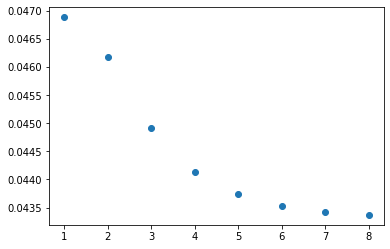

In [3]:
print(solution)
plt.scatter(solution[:,5],solution[:,4])
plt.show()

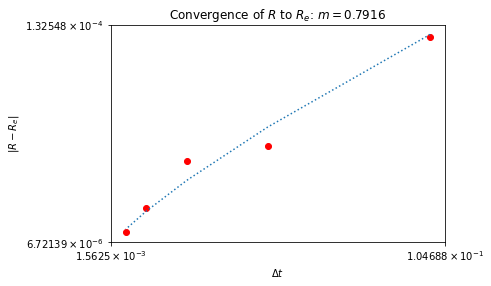

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)

z=np.array([1.0/10, 1.0/20, 1.0/40, 1.0/80, 1.0/160]) #start at 1, to avoid error from log(0)
y=np.array([0.000125391, 0.0000621734, 0.0000535713, 0.0000261519, 0.0000124408])
logA = np.log(z) #no need for list comprehension since all z values >= 1
logB = np.log(y)

m, c = np.polyfit(logA, logB, 1) # fit log(y) = m*log(x) + c
y_fit = np.exp(m*logA + c) # calculate the fitted values of y 

plt.scatter(z, y, color = 'r')
plt.plot(z, y_fit, ':')

ax.set_yscale('symlog')
ax.set_xscale('symlog')
#slope, intercept = np.polyfit(logA, logB, 1)

plt.xlabel("$\Delta t$")
plt.ylabel("$|R-R_e|$")
ax.set_title('Convergence of $R$ to $R_e$: $m=0.7916$')
plt.show()


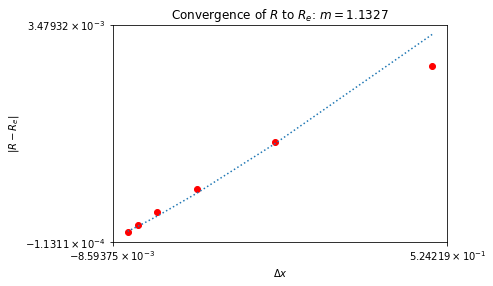

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)

z=np.array([1.0/2, 1.0/4, 1.0/8, 1.0/16, 1.0/32, 1.0/64]) #start at 1, to avoid error from log(0)
y=np.array([0.0027981984, 0.0015368914, 0.0007583413, 0.0003750553, 0.0001663961, 0.0000501820])
logA = np.log(z) #no need for list comprehension since all z values >= 1
logB = np.log(y)

m, c = np.polyfit(logA, logB, 1) # fit log(y) = m*log(x) + c
y_fit = np.exp(m*logA + c) # calculate the fitted values of y 

plt.scatter(z, y, color = 'r')
plt.plot(z, y_fit, ':')

ax.set_yscale('symlog')
ax.set_xscale('symlog')
#slope, intercept = np.polyfit(logA, logB, 1)

plt.xlabel("$\Delta x$")
plt.ylabel("$|R-R_e|$")
ax.set_title('Convergence of $R$ to $R_e$: $m=1.1327$')
plt.show()

In [ ]:
from re import M
import numpy as np
import csv
import matplotlib.pyplot as plt


def best_fit_line(x_values, y_values):
    """Returns slope and y-intercept of the best fit line of the values"""

    mean = lambda l: sum(l)/len(l)
    multiply = lambda l1, l2: [a*b for a, b in zip(l1, l2)]

    m = ( (mean(x_values)*mean(y_values) - mean(multiply(x_values, y_values))) / 
          (mean(x_values)**2             - mean(multiply(x_values, x_values))) )

    b = mean(y_values) - m*mean(x_values)

    return m, b


# with open('FDFE_time.csv', mode='r', encoding='utf-8-sig') as csvfile:
#     data = [[float(dt), float(L2),float(H1), float(m)] for dt, L2, H1, m in csv.reader(csvfile, delimiter= ',')]
with open('FDFE_time2.csv', mode='r', encoding='utf-8-sig') as csvfile:
   data = [[float(dt), float(L2),float(H1), float(m)] for dt, L2, H1, m in csv.reader(csvfile, delimiter= ',')]


x = np.log(np.array(data)[:,0])
y1 = np.log(np.array(data)[:,1])
y2 = np.log(np.array(data)[:,2])
y3 = np.log(np.array(data)[:,3])
print(best_fit_line(x, y1))
print(best_fit_line(x, y2))
print(best_fit_line(x, y3))

fig, ax = plt.subplots(3)
# fig.suptitle('Backward Euler')
fig.suptitle('Crank-Nicolson')
ax[0].scatter(x, y1)
ax[1].scatter(x, y2) 
ax[2].scatter(x, y3)  
ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y1, 1))(np.unique(x)))
ax[1].plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)))
ax[2].plot(np.unique(x), np.poly1d(np.polyfit(x, y3, 1))(np.unique(x)))
ax[0].set_xlabel(r'$\log \Delta t$')
ax[0].set_ylabel(r'$\log || u - u_h || _{L_2}$')
ax[1].set_xlabel(r'$\log \Delta t$')
ax[1].set_ylabel(r'$\log || u - u_h || _{H_1}$')
ax[2].set_xlabel(r'$\log \Delta t$')
ax[2].set_ylabel(r'$\log || u - u_h || _{\infty}$')
plt.show()